<a href="https://colab.research.google.com/github/JosephJang7/projects/blob/main/Mining_Projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()
df = pd.read_csv('mining_project_information.csv')


Saving mining_project_information.csv to mining_project_information (1).csv


In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

df.columns = ["Project", "Capex", "IRR", "CO2", "SScore"]

CAPEX_LIMIT = 1_000         # C$ millions
GNA_IRR     = 10            # % return from Corporate G&A
GNA_NAME    = "I - Corporate G&A"

df = df[~df["Project"].str.contains(GNA_NAME)].reset_index(drop=True)

rows = []
seen = set()

for r in range(1, len(df) + 1):
    for idx in itertools.combinations(df.index, r):
        sel        = df.loc[list(idx)]
        capex_used = sel["Capex"].sum()
        if capex_used > CAPEX_LIMIT:
            continue

        gna_capex = CAPEX_LIMIT - capex_used
        projects  = sorted(sel["Project"].tolist())

        if gna_capex > 0 and GNA_NAME not in projects:
            projects.append(GNA_NAME)

        if gna_capex == 0 and GNA_NAME in projects:
            continue

        if projects.count(GNA_NAME) > 1:
            continue

        key = (frozenset(projects), gna_capex)
        if key in seen:
            continue
        seen.add(key)

        weighted_irr = (sel["IRR"] * sel["Capex"]).sum() + gna_capex * GNA_IRR
        port_irr     = weighted_irr / CAPEX_LIMIT
        co2_total    = sel["CO2"].sum()
        comp_score   = port_irr + 0.05 * co2_total

        rows.append({
            "Projects"          : ", ".join(projects),
            "Total_CAPEX"       : capex_used,
            "Unused_CAP"         : gna_capex,
            "Portfolio_IRR" : round(port_irr, 2),
            "CO2_Avoided_kt"    : co2_total,
            "Composite_Score"   : round(comp_score, 4)
        })

out = pd.DataFrame(rows)
out = out.sort_values("Composite_Score", ascending=False).reset_index(drop=True)

out.to_csv("valid_ranked_combinations.csv", index=False)

out.head(20)

,Projects,Total_CAPEX,Unused_CAP,Portfolio_IRR,CO2_Avoided_kt,Composite_Score
0,"B - Kidd Operations, D - EVR Methane, F - Sudb...",1000,0,20.85,182.5,29.975
1,"A - Raglan Mine, B - Kidd Operations, D - EVR ...",900,100,19.05,207.5,29.425
2,"C - CCR Refinery, D - EVR Methane, H - Antapaccay",1000,0,16.90,217.5,27.775
3,"A - Raglan Mine, C - CCR Refinery, D - EVR Met...",1000,0,17.15,205.0,27.400
4,"A - Raglan Mine, C - CCR Refinery, F - Sudbury...",1000,0,19.10,155.0,26.850
5,"B - Kidd Operations, C - CCR Refinery, H - Ant...",950,50,18.00,175.0,26.750
6,"C - CCR Refinery, D - EVR Methane, F - Sudbury...",950,50,18.35,167.5,26.725
7,"A - Raglan Mine, G - CEZinc Refinery, H - Anta...",1000,0,17.25,187.5,26.625
8,"D - EVR Methane, G - CEZinc Refinery, H - Anta...",950,50,16.50,200.0,26.500
9,"A - Raglan Mine, B - Kidd Operations, C - CCR ...",950,50,18.25,162.5,26.375


In [ ]:
out.to_csv("valid_ranked_combinations.csv", index=False)


In [ ]:
out.count()

,0
Projects,63
Total_CAPEX,63
Unused_CAP,63
Portfolio_IRR,63
CO2_Avoided_kt,63
Composite_Score,63


In [ ]:
out.to_excel("valid_combinations_under_budget.xlsx", index=False)
from google.colab import files
files.download("valid_combinations_under_budget.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

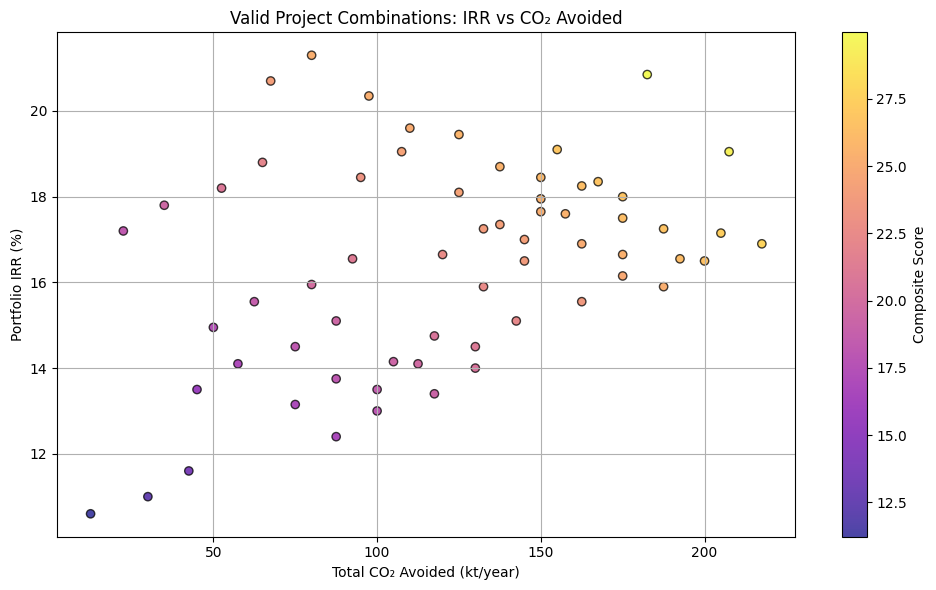

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    out["CO2_Avoided_kt"],
    out["Portfolio_IRR"],
    c=out["Composite_Score"],
    cmap="plasma",
    alpha=0.75,
    edgecolors="k"
)

plt.colorbar(scatter, label="Composite Score")
plt.xlabel("Total CO₂ Avoided (kt/year)")
plt.ylabel("Portfolio IRR (%)")
plt.title("Valid Project Combinations: IRR vs CO₂ Avoided")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install plotly


In [ ]:
import plotly.express as px

fig = px.scatter(
    out,
    x="CO2_Avoided_kt",
    y="Portfolio_IRR",
    color="Composite_Score",
    color_continuous_scale="plasma",
    hover_data=["Projects", "Total_CAPEX", "Unused_CAP"],
    labels={
        "CO2_Avoided_kt": "Total CO₂ Avoided (kt/year)",
        "Portfolio_IRR":   "Portfolio IRR (%)",
        "Composite_Score": "Composite Score"
    },
    title="Valid Project Combinations: IRR vs CO₂ Avoided"
)

fig.update_layout(
    height=800,              # adjust this value as needed
    margin=dict(t=50, b=50)  # leave some top/bottom margin
)

y_min = out["Portfolio_IRR"].min() - 1  # 1% below the lowest point
y_max = out["Portfolio_IRR"].max() + 1  # 1% above the highest point
fig.update_yaxes(range=[y_min, y_max])

fig.update_traces(marker=dict(size=8, line=dict(width=1, color="DarkSlateGrey")))
fig.update_layout(coloraxis_colorbar=dict(title="Composite Score"))

fig.show()



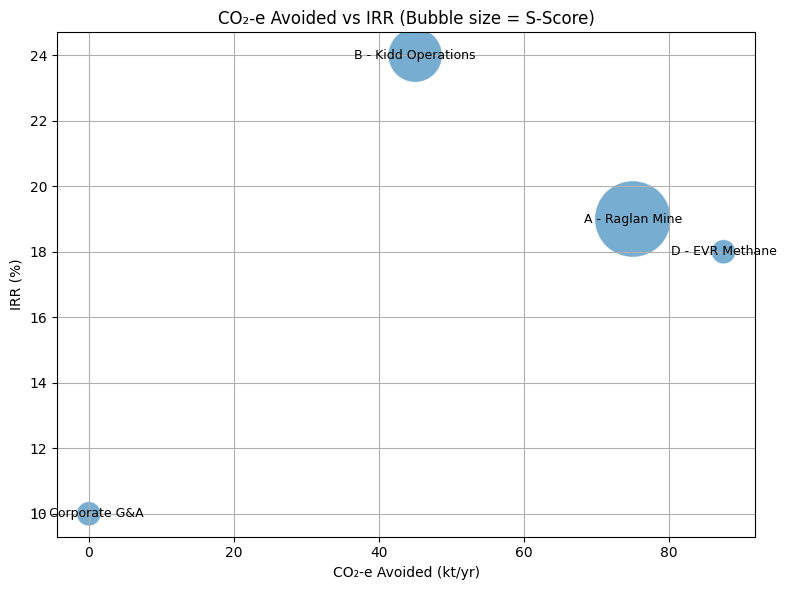

In [ ]:
data = {
    "Projects": ["A - Raglan Mine", "B - Kidd Operations", "D - EVR Methane", "I - Corporate G&A"],
    "IRR (%)": [19, 24, 18, 10],
    "CO2-e Avoided (kt/yr)": [75, 45, 87.5, 0],
    "S-Score": [3, 2, 1, 1]
}

df = pd.DataFrame(data)

size_map = {1: 300, 2: 1500, 3: 3000}
bubble_sizes = df["S-Score"].map(size_map)

plt.figure(figsize=(8, 6))
plt.scatter(
    df["CO2-e Avoided (kt/yr)"],  # X‐axis
    df["IRR (%)"],                # Y‐axis
    s=bubble_sizes,
    alpha=0.6,
    edgecolors="w",
    linewidth=0.5
)

for idx, row in df.iterrows():
    plt.text(
        row["CO2-e Avoided (kt/yr)"],
        row["IRR (%)"],
        row["Projects"],
        fontsize=9,
        ha="center",
        va="center"
    )

plt.xlabel("CO₂-e Avoided (kt/yr)")
plt.ylabel("IRR (%)")
plt.title("CO₂-e Avoided vs IRR (Bubble size = S-Score)")
plt.grid(True)
plt.tight_layout()
plt.show()